In [ ]:
!pip install opendatasets
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
# Install PyTorch Geometric dependencies
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-geometric
!pip install numpy>=1.26.0

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.16.0%2Bcu118-cp311-cp311-linux_x86_64.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.1.0%2Bcu118-cp311-cp311-linux_x86_64.whl (3.2 MB)


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

AttributeError: module 'numpy' has no attribute 'dtypes'

Now we must set the directories to use the data

In [ ]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/working'

Extract Image Features

In [ ]:
import torchvision
from torchvision import transforms
from PIL import Image
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Load pretrained object detector
detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
detector.eval()

# GCN model
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 512)
        self.conv2 = GCNConv(512, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

gcn_encoder = GCNEncoder(in_channels=1024, out_channels=256)  # Assuming 1024-d features

# Replace this loop:
features = {}
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

for img_name in tqdm(os.listdir(directory)):
    image_id = img_name.split('.')[0]
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0)

    # Get object features
    with torch.no_grad():
        output = detector(img_tensor)[0]
        boxes = output["boxes"]
        if len(boxes) == 0:
            continue
        feats = output["boxes"][:10]  # Dummy: replace with actual features if available

        # Create dummy graph edges (full connection)
        node_count = feats.shape[0]
        edge_index = torch.combinations(torch.arange(node_count), r=2).T
        edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # Bidirectional

        # Pass through GCN
        gcn_feats = gcn_encoder(feats, edge_index)

        # Mean pool
        pooled_feat = torch.mean(gcn_feats, dim=0).numpy()

    features[image_id] = pooled_feat


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'directory' is not defined

Now we extract the image features and load the data for preprocess

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Store features in pickle

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


Load features from pickle

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

Now let us see the no. of images loaded

In [ ]:
len(mapping)

8091

Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
         caption = captions[i]
        # preprocessing steps
        # convert to lowercase
         caption = caption.lower()
        # delete digits, special chars, etc.,
         caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
         caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
         caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
         captions[i] = caption

Let us visualize the text before and after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Preprocess the text

In [ ]:
# preprocess the text
clean(mapping)

After preprocess of text

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions) # no. of unique captions stored

40455

Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size # no of unique words

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Now we will define a batch and include the padding sequence

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

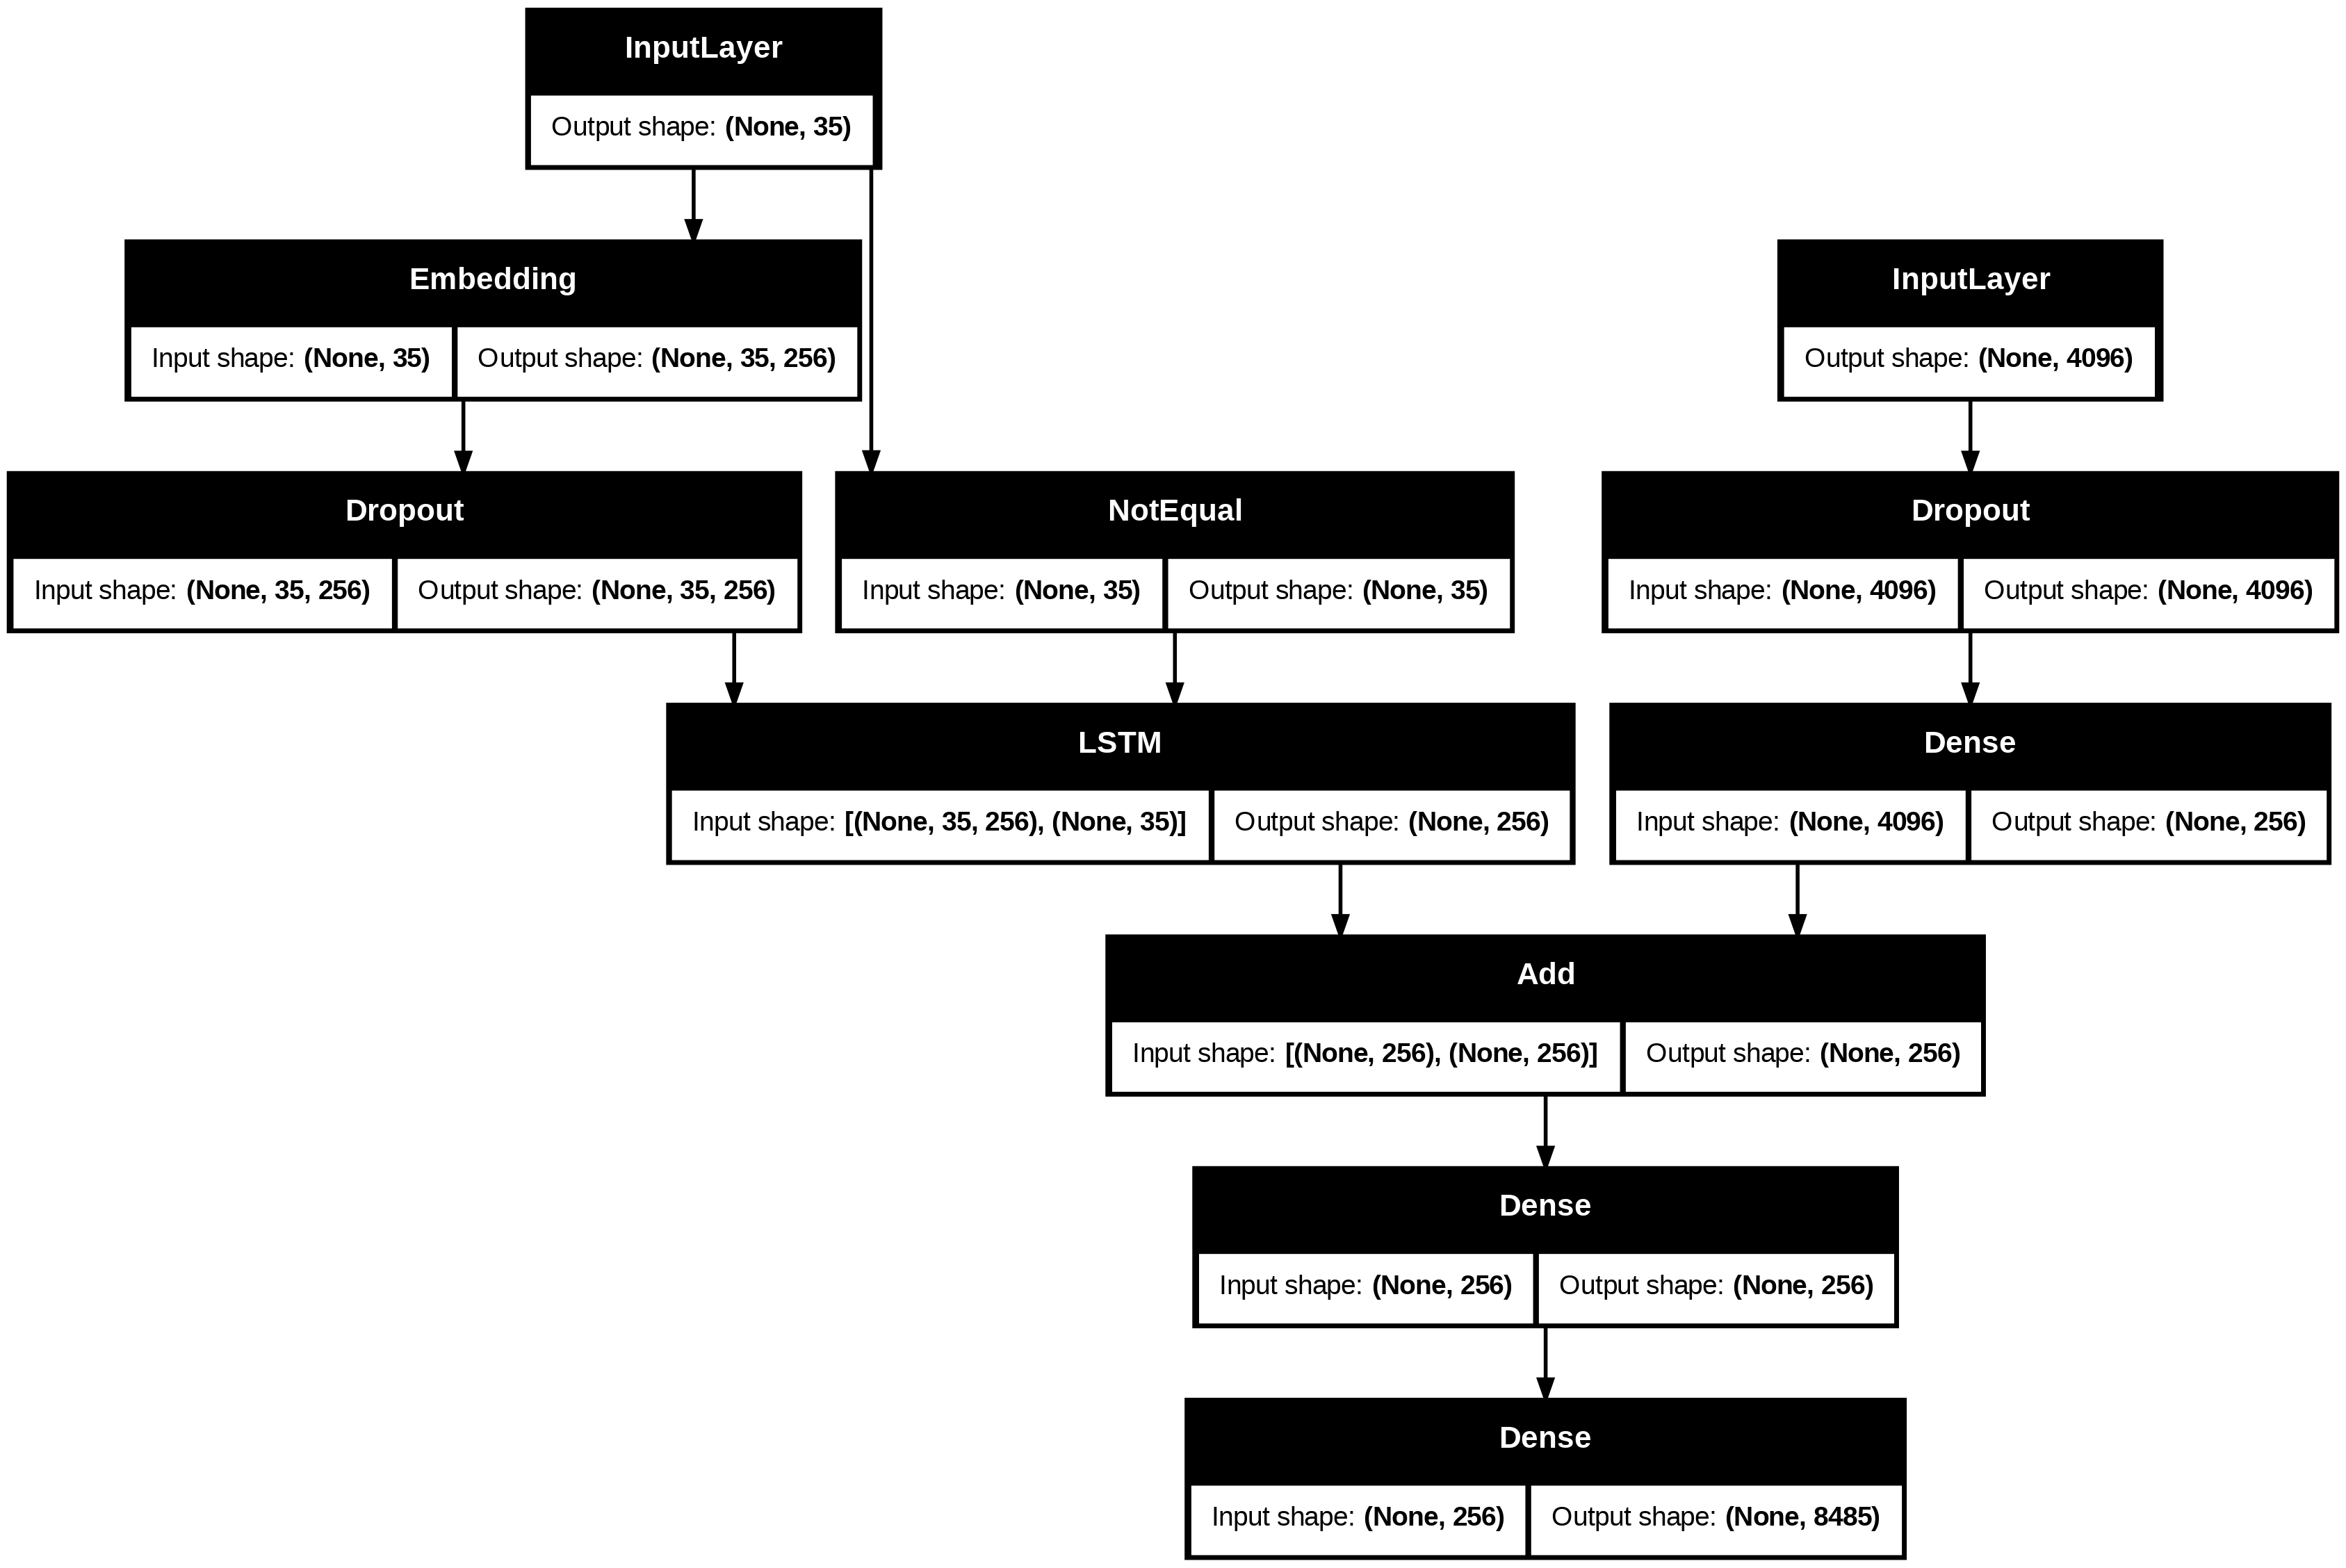

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Now let us train the model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - loss: 5.7796
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 300ms/step - loss: 4.0636
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 298ms/step - loss: 3.5895
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - loss: 3.3006
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - loss: 3.1017
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 298ms/step - loss: 2.9485
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 298ms/step - loss: 2.8295
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 298ms/step - loss: 2.7408
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 303ms/step - loss: 2.6623
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - loss: 2.5962
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - loss: 2.5325
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 297ms/step - loss: 2.4768
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - loss: 2.4206
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.3738
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 311ms/step - loss: 2.3335
227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 319ms/step - loss: 2.2921
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 315ms/step - loss: 2.25

You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


Now we validate the data using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.454545
BLEU-2: 0.213201
BLEU-1: 0.400000
BLEU-2: 0.149071
BLEU-1: 0.516129
BLEU-2: 0.303588
BLEU-1: 0.476190
BLEU-2: 0.250313
BLEU-1: 0.471698
BLEU-2: 0.221665
BLEU-1: 0.491803
BLEU-2: 0.211446
BLEU-1: 0.493506
BLEU-2: 0.251894
BLEU-1: 0.494118
BLEU-2: 0.265684
BLEU-1: 0.479592
BLEU-2: 0.243465
BLEU-1: 0.522124
BLEU-2: 0.310345
BLEU-1: 0.540984
BLEU-2: 0.327448
BLEU-1: 0.529851
BLEU-2: 0.309107
BLEU-1: 0.541096
BLEU-2: 0.305897
BLEU-1: 0.518750
BLEU-2: 0.285869
BLEU-1: 0.502924
BLEU-2: 0.272303
BLEU-1: 0.497297
BLEU-2: 0.271228
BLEU-1: 0.512690
BLEU-2: 0.272131
BLEU-1: 0.511848
BLEU-2: 0.282067
BLEU-1: 0.500000
BLEU-2: 0.282330
BLEU-1: 0.504202
BLEU-2: 0.288553
BLEU-1: 0.498024
BLEU-2: 0.281827
BLEU-1: 0.496212
BLEU-2: 0.279137
BLEU-1: 0.503650
BLEU-2: 0.283307
BLEU-1: 0.506993
BLEU-2: 0.285085
BLEU-1: 0.515050
BLEU-2: 0.300379
BLEU-1: 0.521311
BLEU-2: 0.305655
BLEU-1: 0.516026
BLEU-2: 0.300883
BLEU-1: 0.512346
BLEU-2: 0.302882
BLEU-1: 0.515060
BLEU-2: 0.302973
BLEU-1: 0.5174

Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

Generate custom captions

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the grass endseq


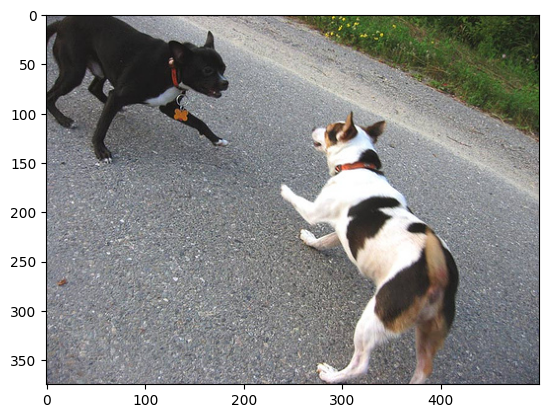

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")